In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Pobierz zbiór danych - katalogi unlabeled_undirected i rest to nasze kategorie
import pathlib
data_dir = '../graph_generator'
data_dir = pathlib.Path(data_dir)

In [3]:
# Po pobraniu powinieneś mieć teraz dostępną kopię zbioru danych.
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

250


In [4]:
photos = list(data_dir.glob('unlabeled_undirected/*'))
schemas = list(data_dir.glob('rest/*'))

In [5]:
# Załaduj dane za pomocą narzędzia Keras
batch_size = 32
img_height = 180
img_width = 180

In [6]:
# Dobrą praktyką jest używanie podziału walidacji podczas opracowywania modelu. Użyjmy 80% obrazów do szkolenia, a 20% do walidacji.
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 250 files belonging to 2 classes.
Using 200 files for training.


Found 250 files belonging to 2 classes.
Using 50 files for validation.


In [7]:
# Nazwy klas można znaleźć w atrybucie class_names w tych zestawach danych. Odpowiadają one nazwom katalogów w kolejności alfabetycznej.
class_names = train_ds.class_names
print(class_names)

['rest', 'unlabeled_undirected']


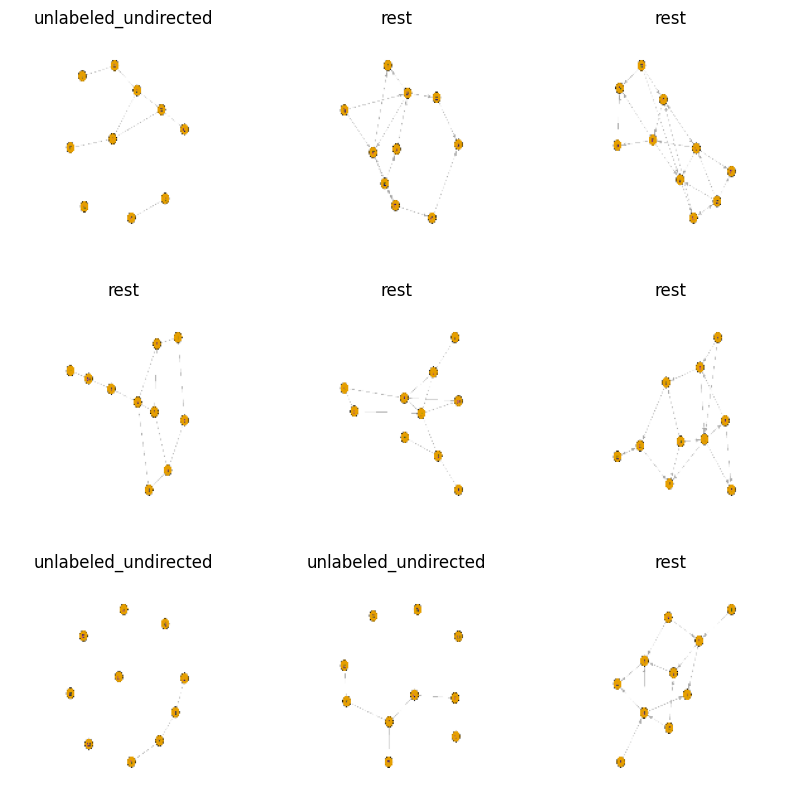

In [8]:
# Wizualizuj dane
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# Standaryzuj dane
normalization_layer = layers.Rescaling(1./255)

In [13]:
# Istnieją dwa sposoby wykorzystania tej warstwy. Możesz zastosować go do zestawu danych, wywołując Dataset.map
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [14]:
# Stwórz model
num_classes = len(class_names)

In [15]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

b:\Projekty\Studia\Semestry\II_stopien_III_semestr\Praca magisterska\graph_classification\env\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Skompiluj model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# Podsumowanie modelu
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,988,898 (15.22 MB)

 Trainable params: 3,988,898 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
#Trenuj model
epochs=75
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.6465 - loss: 2.2011 - val_accuracy: 0.7600 - val_loss: 0.6320
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8146 - loss: 0.5555 - val_accuracy: 0.7600 - val_loss: 0.5630
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.7881 - loss: 0.5375 - val_accuracy: 0.7600 - val_loss: 0.5612
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.8205 - loss: 0.4814 - val_accuracy: 0.7600 - val_loss: 0.5294
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8056 - loss: 0.4868 - val_accuracy: 0.7600 - val_loss: 0.5604
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8409 - loss: 0.4319 - val_accuracy: 0.7600 - val_loss: 0.5218
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8087 - loss: 0.4719 - val_accuracy: 0.7600 - val_loss: 0.6085
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8331 - loss: 0.4249 - val_accuracy: 0.7600 - val_loss: 0.4

In [19]:
# Wizualizuj wyniki treningu
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

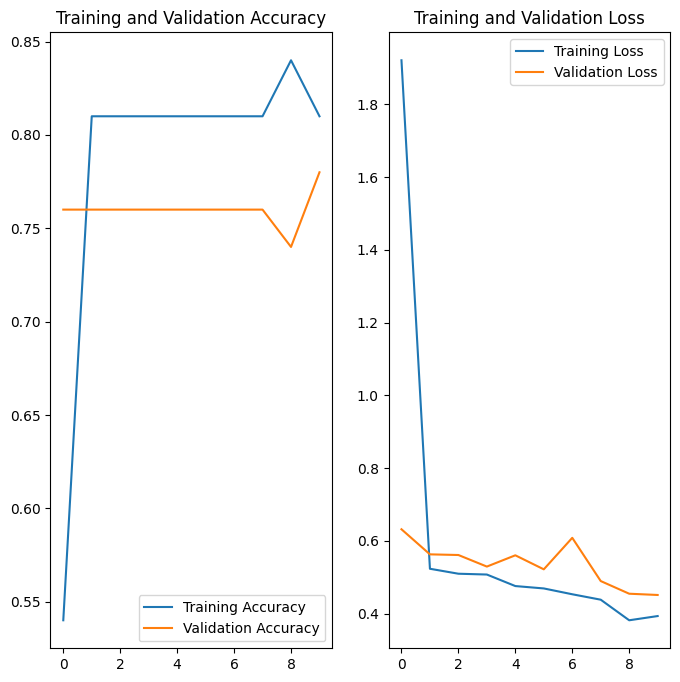

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Dokładność')
plt.xlabel('Epoka')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.show()

In [21]:
# Rozszerzanie danych
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

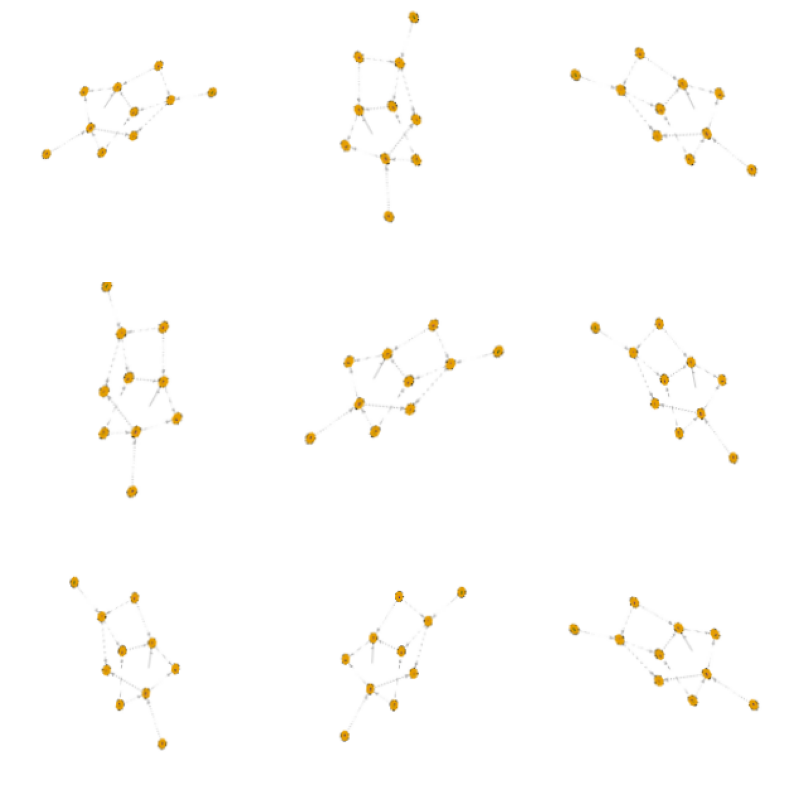

In [22]:
# Zobrazujemy, jak wygląda kilka rozszerzonych przykładów, stosując kilkakrotne rozszerzenie danych do tego samego obrazu:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [23]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
# Skompiluj i trenuj model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.6797 - loss: 1.3434 - val_accuracy: 0.7600 - val_loss: 0.5765
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.8200 - loss: 0.5078 - val_accuracy: 0.7600 - val_loss: 0.5791
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.7811 - loss: 0.5390 - val_accuracy: 0.7600 - val_loss: 0.5316
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.8037 - loss: 0.4945 - val_accuracy: 0.7600 - val_loss: 0.5488
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.8331 - loss: 0.4497 - val_accuracy: 0.7600 - val_loss: 0.5339
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8227 - loss: 0.4679 - val_accuracy: 0.7600 - val_loss: 0.5309
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.7741 - loss: 0.5178 - val_accuracy: 0.7600 - val_loss: 0.5668
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8072 - loss: 0.4803 - val_accuracy: 0.7600 - val_loss:

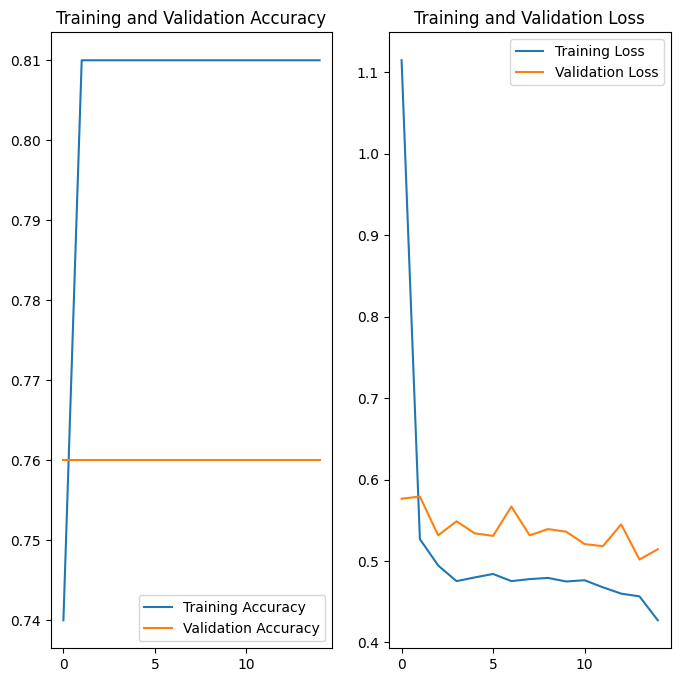

In [25]:
# Wizualizuj wyniki treningu
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
# Przewiduj nowe dane
test_photo_path = 'test_graphs/'
test_photo1 = 'rest-directed-9.png'
test_photo2 = 'unlabeled_undirected-24.png'

img = tf.keras.utils.load_img(
    test_photo_path + test_photo2, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
This image most likely belongs to rest with a 73.16 percent confidence.
